# HPGe gamma energy calibration

HPGe (High Purity germanium) detectors are semiconductors, effectively a large diode. They measure gamma energies from the creation of electron-hole pairs across the band gap. if a gamma photon is fully absorved in the detector the energy deposited corresponds to the total energy of the photon, the photopeak.

The electron-hole current is converted into a voltage pulse using a RC circuit (Resistor Capacitor). The amplitude of the voltage pulse is proportional to the total charge created in the electron-hole cascade, and therefore, the energy of the photon.

The HPGe data corresponds to the recorded list of voltage amplitudes during the entire experiment. It is important to notice that the electronics do not record the amplitudes in units of voltage, but as an internal 32 bit word corresponding to the entire voltage range of the digitizer. A calibration is necessary to convert the internal units into the right energy scale.

Energy calibration can be done with well known radioactive sources, $^{60}Co$ and $^{137}Cs$ are common ones, or by utilizing well stablished photopeaks in the decay of the nucleus of interest.

Let's look at each step individually.


## Set up environment and pacakges

As in a python environment we need to define the packages we'll use



In [3]:
using Plots, DelimitedFiles,LsqFit

include("src/PhotoPeakFit.jl");

default(framestyle=:box,
        mc=:black,
        grid=false,
        guidefont=14,
        tickfont=12,
        lc=:navy,
        xlabel="Eᵧ (internal)",
        ylabel="counts")

## Uncalibrated histogram

In this example we are going to look at clover crystal 01. Each clover has four crystals, and we had three clovers in the experiment, so there are 12 crystals, numbered 0 to 11.

First we need to read the uncalibrated data into an array and plot it. Several gamma photopeaks can be observed. This must correspond to transitions in the decay of $^{47}K$

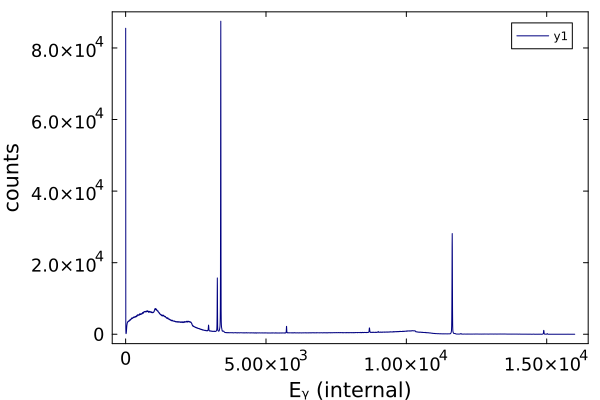

In [4]:
crystal1raw=readdlm("data/K47_T1_001_rawClover_crystal_01.txt",',')

plot(crystal1raw[:,1],crystal1raw[:,2])

## Identifying gamma lines

The list of gamma lines in the decay of $^{47}K$ can be obtained from [NNDC's database ENSDF](https://www.nndc.bnl.gov/ensdf/). I copy the relevant ones here.

The three strongest lines in our histogram must correspond to the strongest lines in the table, the 565, 586, and 2013 keV lines. Although we can do a calibration with three points, a more involved one using $^{137}Cs$ will be done later.

<img src="images/gammas.png" alt="Drawing" style="width: 300px;"/>

## Obtaining the uncalibrated position of each photopeak

Let's zoom in into the pair of strong lines at the lower energies. Although all photon energies are effectively identical, correponding to the energy in the table, the observed voltage distribution correponds to a gaussian. The distribution arises from the statistical uncertainty in the number of electron-hole pairs, $\sigma=\sqrt{N_{e-h}}$ in poisson statistics.

$E_{\gamma}(E)=\frac{A}{\sqrt{2\pi\sigma^2}}e^{\frac{(E-E_o)^2}{2\sigma^2}}$

where $A$ is the area of the transition (the observed intensity), $E_o$ is the mean energy, also called centroid, and $\sigma$ is the variance. 



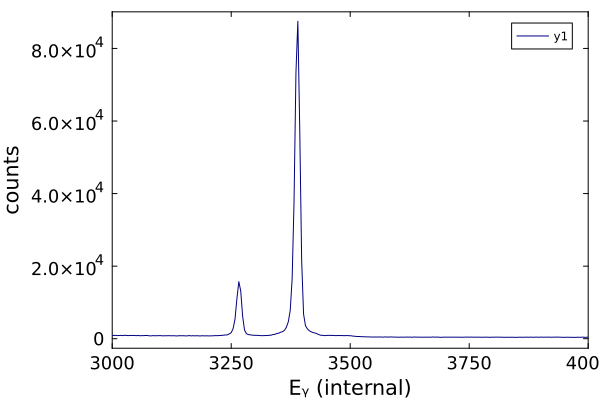

In [5]:
plot(crystal1raw[:,1],crystal1raw[:,2],xlims=(3000,4000))

To calibrate the crystal we must obtain the means for the three transitions we identified in ENSDF. To do so, we fit each transition to a function representing the gaussian plus a linear background.

$fitFunction=a+b\cdot x+E_{\gamma}(E)$

where $a$ and $b$ parametrize the background. The PhotoPeakFit.jl module included in src/ provides tools to do both gaussian and lorentz fits. 

First, we need to provide the fit limits (which part of the histogram we are fitting) and a set of initial fit parameters, written as

`[background-constant, background-slope, area1,mean1,sigma1]`



In [6]:
xlow,xhigh = 3200,3300
param = [100,0.05,2e5,3250,5]

5-element Vector{Float64}:
    100.0
      0.05
 200000.0
   3250.0
      5.0

Now we can use the gaussianfit function in the provided module to fit. It returns three elements, the parameter list, the uncertainties, and the fitting fucntion (for latter plotting). The mean correspnds to parameter 4.

P1 = -8123.169344639424(6657.972091705674)
P2 = 2.8174076469255565(2.0526500734017716)
P3 = 196735.4492296335(3714.2780032792666)
P4 = 3266.4390083093094(0.09281745707060604)
P5 = 5.361580557583666(0.10104676568321055)


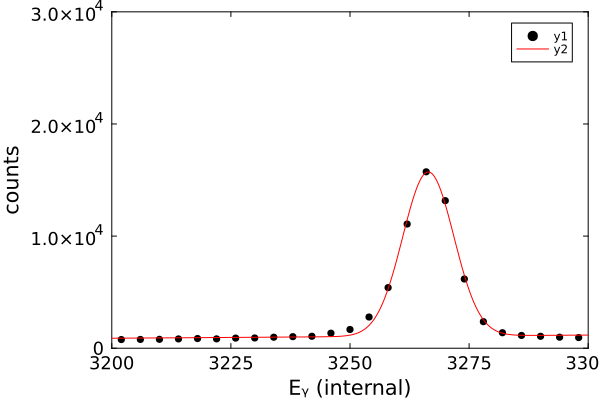

In [7]:
p564,s564,f=PhotopeakFit.gaussianfit(crystal1raw,xlow,xhigh,param)

for (i,val) in enumerate(p564)
    println("P$i = ",val,"($(s564[i]))")
end

scatter(crystal1raw[:,1],crystal1raw[:,2],xlims=(xlow,xhigh),ylims=(0,3e4))
plot!(e->f(e,p564),xlow,xhigh,lc=:red)

We repeat the process with the two remaining peaks

P1 = 12366.79800224689(10407.530610976977)
P2 = -3.2038548158009608(3.0588363481655194)
P3 = 1.1715256742952755e6(14574.638197511284)
P4 = 3388.988561298161(0.07263140377173506)
P5 = 5.482652918697476(0.0746884747371734)


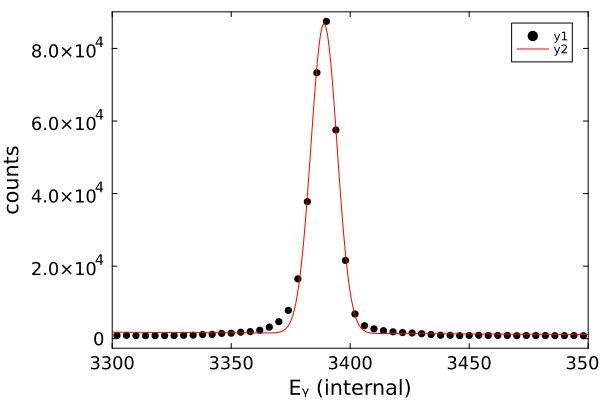

In [8]:
xlow,xhigh = 3300,3500
param = [100,0.05,2e5,3400,5]

p586,s586,f=PhotopeakFit.gaussianfit(crystal1raw,xlow,xhigh,param)

for (i,val) in enumerate(p586)
    println("P$i = ",val,"($(s586[i]))")
end

scatter(crystal1raw[:,1],crystal1raw[:,2],xlims=(xlow,xhigh))
plot!(e->f(e,p586),xlow,xhigh,lc=:red)

P1 = 9226.073542657856(2963.3513388719143)
P2 = -0.7702394486377651(0.2531075385911186)
P3 = 510299.2025616957(3864.1509234533028)
P4 = 11633.534955766343(0.060437666680042766)
P5 = 7.41349811180166(0.06192163245472744)


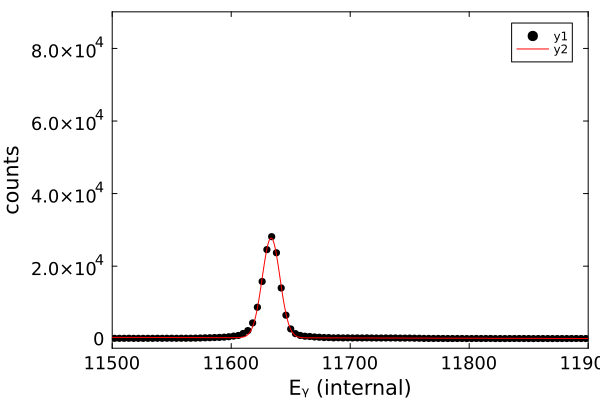

In [9]:
xlow,xhigh = 11500,11900
param = [100,0.05,2e5,11650,5]

p2013,s2013,f=PhotopeakFit.gaussianfit(crystal1raw,xlow,xhigh,param)

for (i,val) in enumerate(p2013)
    println("P$i = ",val,"($(s2013[i]))")
end

scatter(crystal1raw[:,1],crystal1raw[:,2],xlims=(xlow,xhigh))
plot!(e->f(e,p2013),xlow,xhigh,lc=:red)

## Energy calibration

Now that we have the three peaks in internal units we can fit the three means to a linear function. Let's look at a plot the gamma energies v. the three means. While it is a little hard to see because of the very different scale, one can tell the three points are aligned fairly lineraly.


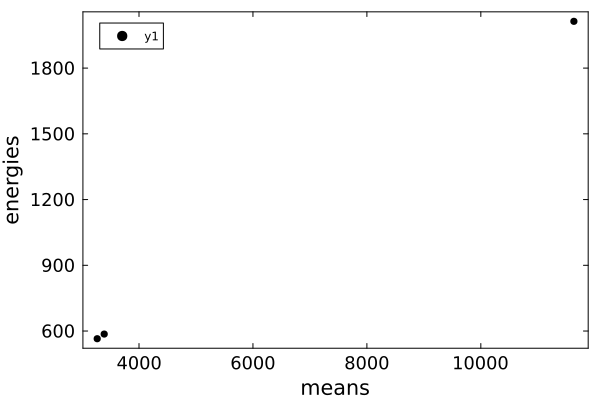

In [10]:
energies = [564.79,586.01,2013.45]; means=[p564[4],p586[4],p2013[4]]

scatter(means,energies,xlabel="means",ylabel="energies")

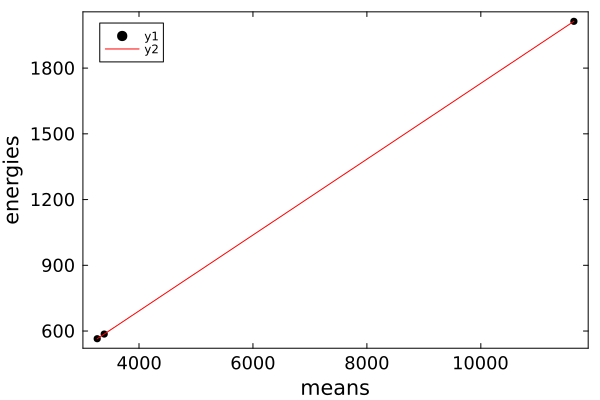

In [11]:

@. linearfit(e,p)=p[1]+p[2]*e

fitcrystal1=curve_fit(linearfit,means,energies,[500,0.15])

scatter(means,energies,xlabel="means",ylabel="energies")
plot!(e->linearfit(e,fitcrystal1.param),lc=:red)

More importantly, we need to plot the residuals to check the quality of the fit

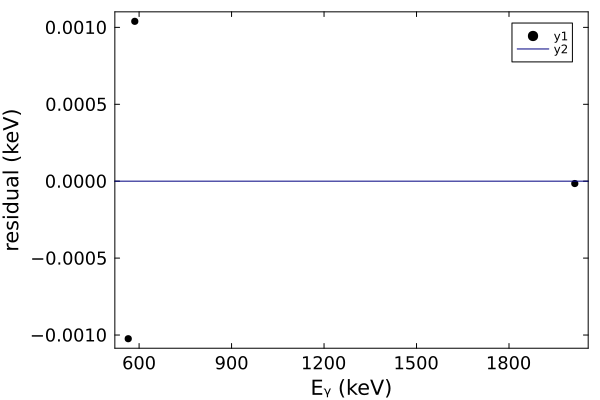

In [12]:
residuals = energies .- ( fitcrystal1.param[1] .+ means .* fitcrystal1.param[2] )

scatter(energies,residuals,xlabel="Eᵧ (keV)",ylabel="residual (keV)")
hline!([0])


## Calibrate the histogram

The final step is to create a new calibrated histogram.

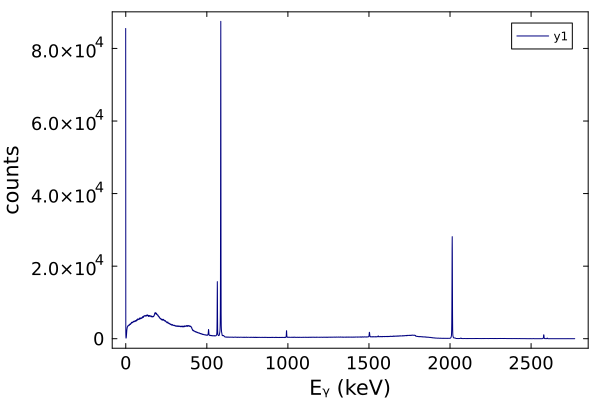

In [13]:
crystal1calibrated = [ fitcrystal1.param[1].+crystal1raw[:,1].*fitcrystal1.param[2] crystal1raw[:,2] ] 

plot(crystal1calibrated[:,1],crystal1calibrated[:,2],xlabel="Eᵧ (keV)")

## Now we can repeat the process for crystals 2 to 11.

WARNING: it is difficult to make this process automatic because the positions of the peaks in internal units may vary wildly between crystals. 

In this particular example for crystal 2 the positions are very close to those of crystal 1, so one can start with the same parameters of crystal 1, allowing for recycling the code above.

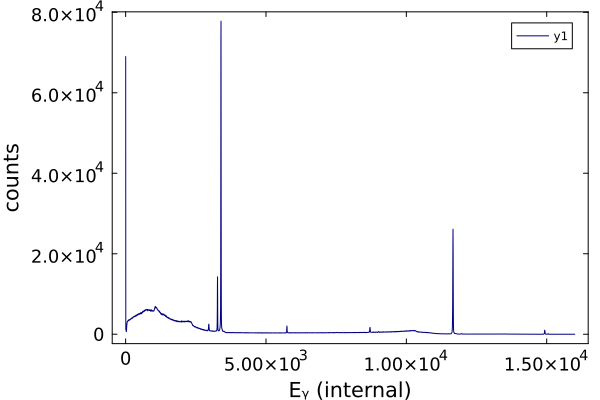

In [14]:
crystal2raw=readdlm("data/K47_T1_001_rawClover_crystal_02.txt",',')

plot(crystal2raw[:,1],crystal2raw[:,2])
